In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

from hnn_core.network import pick_connection
from hnn_core.cell import _get_gaussian_connection

from plot_simulate_rep_L6 import sim_dev_spiking, plot_dev_spiking_v2

Proportion of network driven on std: 0.140625
# driven units (Group 1) on std: 18.0
# driven units (Group 2) on std: 9.0
simulating fully-connected network
MPI will run 5 trial(s) sequentially by distributing network neurons over 6 processes.
numprocs=6
/home/ryan/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/ryan/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/ryan/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/ryan/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://se

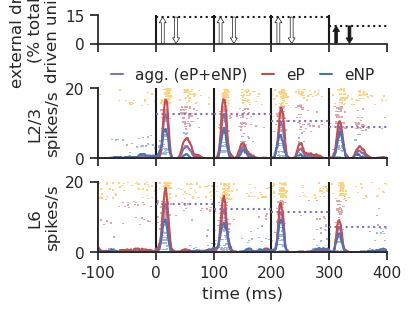

In [79]:
dev_magnitude = -1
n_trials = 5
rng = np.random.default_rng(1234)
burn_in_time = 300.0
n_procs = 6
record_vsec = False

net, drive_params = sim_dev_spiking(dev_magnitude=dev_magnitude,
                                    n_trials=n_trials,
                                    burn_in_time=burn_in_time,
                                    n_procs=n_procs,
                                    record_vsec=record_vsec,
                                    rng=rng)

rep_start_times = drive_params['rep_times']
drive_times = drive_params['drive_times']
drive_strengths = drive_params['drive_strengths']
tstop = drive_params['tstop']

fig_dev_spiking_v2 = plot_dev_spiking_v2(net,
                                         burn_in_time,
                                         rep_start_times,
                                         drive_times,
                                         drive_strengths,
                                         tstop)

In [80]:
def syn_conductance_kernel(t_vec, tau1=10., tau2=20.):
    tp = (tau1 * tau2) / (tau2 - tau1) * np.log(tau2 / tau1)
    norm_factor = 1 / (-np.exp(-tp / tau1) + np.exp(-tp / tau2))
    G = norm_factor * (-np.exp(-t_vec / tau1) + np.exp(-t_vec / tau2))
    return G


def get_conductance_timecourse(net, cell_types, receptor):
    times = net.cell_response.times
    inplane_dist = net._inplane_distance
    spike_times = net.cell_response.spike_times
    spike_gids = net.cell_response.spike_gids
    n_trials = len(spike_times)
    c_total_by_type = dict()

    for cell_type in cell_types:
        tau1 = net.cell_types[cell_type].synapses[receptor]['tau1']
        tau2 = net.cell_types[cell_type].synapses[receptor]['tau2']
        # print(f'{cell_type}: tau 1 {tau1}, tau2 {tau2}')
        gids = net.gid_ranges[cell_type]
        c_total = np.zeros((len(gids), len(times)))
        # get GABAA connections to the desired cell type
        conn_idxs = pick_connection(net, target_gids=cell_type,
                                    receptor=receptor)
        for conn_idx in conn_idxs:
            gid_pairs = net.connectivity[conn_idx]['gid_pairs'].items()
            nc_dict = net.connectivity[conn_idx]['nc_dict']
            src_type = net.connectivity[conn_idx]['src_type']
            src_gid_max = np.max(net.gid_ranges[src_type])
            # for each source, find spikes and map their responses to targets
            for src_gid, targ_gids in gid_pairs:
                src_gid_idx = np.nonzero(
                    np.in1d(src_gid, net.gid_ranges[src_type]))[0][0]
                src_pos = net.pos_dict[src_type][src_gid_idx]

                # get all source spike times
                for trial_idx in range(n_trials):
                    spike_idxs = np.nonzero(
                        np.array(spike_gids[trial_idx]) == src_gid)[0]
                    src_spike_times = np.array(spike_times[trial_idx])
                    src_spike_times = src_spike_times[spike_idxs]
                    # get time window following each spike
                    for src_spike_time in src_spike_times:
                        time_after_idxs = times >= src_spike_time
                        # time samples after the spike occured
                        times_after = times[time_after_idxs]
                        times_after -= times_after[0]
                        # for each spike time, get target information,
                        # calculate post-synaptic response, and add to
                        # cumulative post-synaptic conductance timecourse
                        for targ_gid in targ_gids:
                            targ_gid_idx = np.nonzero(
                                np.in1d(targ_gid,
                                        net.gid_ranges[cell_type]))[0][0]
                            targ_pos = net.pos_dict[cell_type][targ_gid_idx]
                            g_bar, _ = _get_gaussian_connection(src_pos,
                                                                targ_pos,
                                                                nc_dict,
                                                                inplane_dist)
                            post_syn_cond = g_bar * syn_conductance_kernel(
                                times_after, tau1=tau1, tau2=tau2
                            )
                            c_total[targ_gid_idx,
                                    time_after_idxs] += post_syn_cond
        c_total_by_type[cell_type] = c_total

    return c_total_by_type

In [81]:
c_total_by_type = get_conductance_timecourse(net, ['L2e_1', 'L2e_2'], 'gabaa')

Text(0.5, 0, 'eNP')

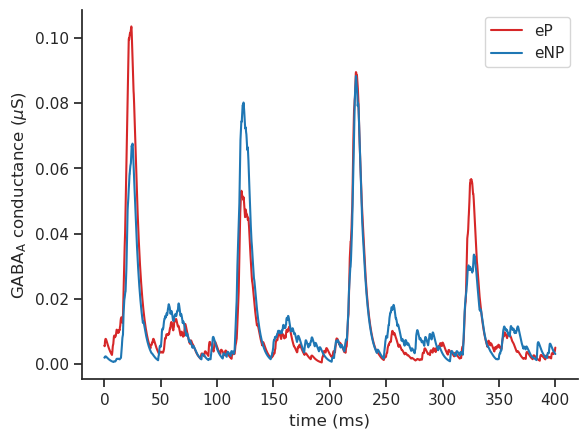

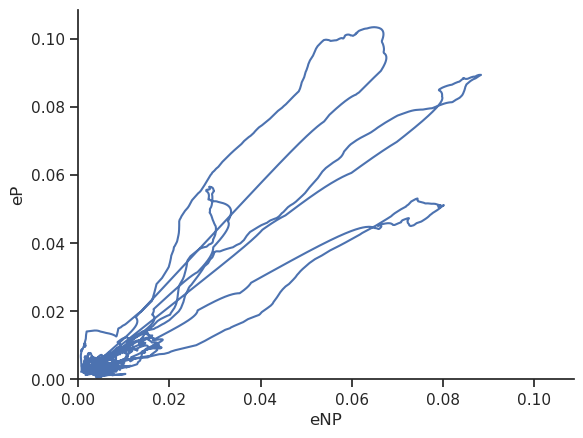

In [84]:
times = net.cell_response.times
n_trials = len(net.cell_response.spike_times)
post_burn_in_idxs = times >= burn_in_time
times_post_burn_in = times[post_burn_in_idxs] - burn_in_time

g_1_avg = c_total_by_type['L2e_1'].mean(axis=0) / n_trials
g_1_avg = g_1_avg[post_burn_in_idxs]
g_2_avg = c_total_by_type['L2e_2'].mean(axis=0) / n_trials
g_2_avg = g_2_avg[post_burn_in_idxs]

plt.figure()
plt.plot(times_post_burn_in, g_1_avg, c='tab:red')
plt.plot(times_post_burn_in, g_2_avg, c='tab:blue')
plt.ylabel('$\mathregular{GABA_A}$ conductance ($\mu$S)')
plt.xlabel('time (ms)')
plt.legend(['eP', 'eNP'])


plt.figure()
plt.plot(g_2_avg, g_1_avg)
ax = plt.gca()
lim_max = np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
plt.xlim([0, lim_max])
plt.ylim([0, lim_max])
plt.ylabel('eP')
plt.xlabel('eNP')

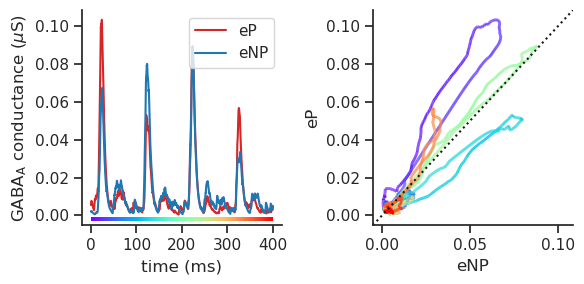

In [132]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].plot(times_post_burn_in, g_1_avg, c='tab:red')
axes[0].plot(times_post_burn_in, g_2_avg, c='tab:blue')
axes[0].set_xticks(np.arange(0, times_post_burn_in[-1], 100.0))
axes[0].set_ylabel('$\mathregular{GABA_A}$ conductance ($\mu$S)')
axes[0].set_xlabel('time (ms)')
axes[0].legend(['eP', 'eNP'])
cax = axes[0].inset_axes([0.0, -0.003, 400, 0.002], transform=axes[0].transData)

# Create a set of line segments so that we can color them individually
# This creates the points as an N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([g_2_avg, g_1_avg]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(times_post_burn_in.min(), times_post_burn_in.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
# Set the values used for colormapping
lc.set_array(times_post_burn_in)
lc.set_linewidth(2)
line = axes[1].add_collection(lc)
# place colorbar along x-axis of 1st plot
cbar = fig.colorbar(line, cax=cax, orientation='horizontal')
cbar.outline.set_visible(False)
cbar.set_ticks([])

lim_max = np.max([g_2_avg, g_1_avg])
lim = [-lim_max * 0.05, lim_max * 1.05]
axes[1].plot(lim, lim, c='k', ls=':')
axes[1].set_xlim(lim)
axes[1].set_ylim(lim)
axes[1].set_ylabel('eP')
axes[1].set_xlabel('eNP')

axes[0].set_ylim(lim)  # update 1st plot as well

fig.tight_layout()
plt.show()